In [23]:
import numpy as np
from numpy.linalg import pinv, svd, eigvals

import matplotlib.pyplot as plt
%matplotlib inline

# --> SciPy utility functions for discrete-time linear systems.
from scipy.signal import dlti, dlsim, lti, lsim
from scipy.signal import correlate, welch, csd
from scipy.fft import fft, fftfreq

# Identifying a state-space model from data : EigenRealization Algorithm

Identifying a state-space model of a system from input/output data only has become relatively common in different engineering fields.
A plethorea of techniques can be used to identify a dynamical model.
Yet, we will restrict ourselves to assuming that the system behaves linearly.
Doing so enables us to use advanced linear algebra techniques to easily and robustly identify a model.
In the rest of this notebook, we'll assume that our system can be modeled as

$$
\begin{aligned}
\mathbf{x}_{k+1} & = \mathbf{Ax}_k + \mathbf{Bu}_k \\
\mathbf{y}_k & = \mathbf{Cx}_k + \mathbf{Du}_k,
\end{aligned}
$$

where $\mathbf{x} \in \mathbb{R}^n$ is the state of the system and $\mathbf{A} \in \mathbb{R}^{n \times n}$ is the dynamics matrix.
The matrices $\mathbf{B} \in \mathbb{R}^{n \times p}$, $\mathbf{C} \in \mathbb{R}^{q \times n}$ and $\mathbf{D} \in \mathbb{R}^{q \times p}$ are the **input-to-state**, **state-to-output** and **input-to-output** matrices.
We will furthemore suppose that both the full state $\mathbf{x}$ and the different matrices (and their dimensions) are unknown to us.
The only piece of information we have are input/output data, i.e. $\left\{ \mathbf{u}_k, \mathbf{y}_k \right\}_{k = 1, \cdots, N}$.
Two situations will be considered :
1. $\left\{ \mathbf{u}_k, \mathbf{y}_k \right\}_{k = 1, \cdots, N}$ corresponds to the impulse response of the system.
2. The impulse response is not available and $\left\{ \mathbf{u}_k, \mathbf{y}_k \right\}_{k = 1, \cdots, N}$ thus corresponds to pseudo-random inputs and the corresponding output.

We could also assume that the output measurements $\mathbf{y}_k$ are corrupted by sensor noise.

For the sake of simplicity, we'll consider a simple physical system: the *damped harmonic oscillator* with input.
Its govering equation reads

$$
\ddot{x} = -2\xi \dot{x} - x + u.
$$

Introducing the change of variable $v = \dot{x}$, it can be cast as a system of two ordinary differential equations, i.e.

$$
\begin{aligned}
\dot{x} & = v \\
\dot{v} & = -2\xi v - x + u
\end{aligned}
$$

or equivalently in matrix form

$$
\dfrac{d}{dt}
\begin{bmatrix}
x \\ v
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 \\
-1 & -2\xi
\end{bmatrix}
\begin{bmatrix}
x \\ v
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 1
\end{bmatrix}
u.
$$

As in most engineering situations, this model is a continuous-time one.
Yet, in the rest of this notebook, you'll have to identify a discrete-time version of it.
We'll assume finally that only the position $x(t)$ is observed.

## Collecting the impulse response

The cell below implements the construction of our supposedly unknown system and the collection of its impulse response data.

In [2]:
# --> Construct the matrices.
def build_system(ξ=0.1):
    # --> Dynamics matrix.
    A = np.array([
        [0.0, 1.0],
        [-1.0, -2*ξ]])
    
    # --> Input-to-state matrix.
    B = np.array([[0.0], [1.0]])
    
    # --> State-to-output matrix.
    C = np.array([[1.0, 0.0]])
    
    # --> Input-to-output matrix.
    D = np.array([[0.0]])
    
    return lti(A, B, C, D)

# --> Instantiate the system.
sys = build_system()

# --> Generate impulse response data.
t, y = sys.impulse(T=np.linspace(0, 400, 4001))
Δt = t[1] - t[0] # Sampling time.

Let us now plot it.
This is done below.

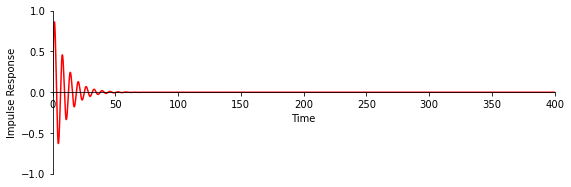

In [3]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t, y, c="r")

ax.set(xlim=(0, t.max()), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

For the time being, this impulse response is the only piece of data available to you.
Your goal will be to identify a discrete-time state-space model of the harmonic oscillator from this impulse response.

## EigenRealization Algorithm

Given the impulse response of the system, it is possible to identify a state-space model using the [EigenRealization Algorithm](https://en.wikipedia.org/wiki/Eigensystem_realization_algorithm), see also [Steve Brunton's Control Bootcamp](https://www.youtube.com/watch?v=QDlWRWbFvhg&ab_channel=SteveBrunton).
Our goal is to identify a state-space model of the form

$$
\begin{aligned}
\hat{\mathbf{x}}_{k+1} & = \hat{\mathbf{A}}\hat{\mathbf{x}}_k + \hat{\mathbf{B}} \mathbf{u}_k \\
\mathbf{y}_k & = \hat{\mathbf{C}} \hat{\mathbf{x}}_k + \mathbf{Du}_k.
\end{aligned}
$$

The internal state $\hat{\mathbf{x}}$ cannot be readily interpreted as the position and velocity of our oscillator.
Instead, it corresponds to an arbitrary linear transformation of these.
Moreover, the model is now expressed in discrete-time rather than continuous time.
Nonetheless, it offers some insights into the fundamental properties of the original system.
In particular, the eigenvalues $\mu$ of $\hat{\mathbf{A}}$ are related to the eigenvalues $\lambda$ of $\mathbf{A}$ through the transformation

$$
\lambda = \dfrac{\log(\mu)}{\Delta t}
$$

where we use the complex logarithm and $\Delta t$ is our sampling period.
Even though we don't know what the original system is, we can infer its dominant complex frequencies from the identified model.
This is widely used when studying the vibration dynamics of fairly complicated structures for which deriving the equations of motion from first principles and computing the eigenvalues might be quite challenging.

It is now up to you to implement the ERA algorithm and identified such a model from the impulse response computed previously.

In [4]:
# --> Define Hankel matrix function.
#Hankel = lambda y, n: np.asarray([y[i:-n+i] for i in range(n)])
def Hankel(y):
    
    # --> Ensure that we have an odd number of elements.
    if len(y)%2 != 0:
        y = y[:-1]
    
    # --> Size of the Hankel matrix.
    n = len(y)//2
    
    # --> Create the container.
    H = np.empty((n, n))
    
    # --> Fill-in the rows.
    for i in range(n):
        H[i, :] = y[i:-n+i]
        
    return H

In [5]:
# --> Extract the feedthrough matrix and discard y[0].
D, y_new = y[0], y[1:]

In [6]:
# --> Form the first Hankel matrix.
H = Hankel(y_new[:-1])

In [7]:
# --> Singular Value Decomposition of the Hankel matrix.
U, Σ, Vt = np.linalg.svd(H)

[(-1.0, 30.0), Text(0, 0.5, 'Σᵢ')]

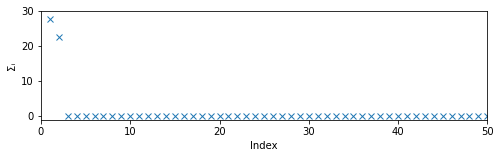

In [8]:
# --> Plot the singular value spectrum.
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(range(1, len(Σ)+1), Σ, "x")

ax.set(xlim=(0, 50), xlabel="Index")
ax.set(ylim=(-1, 30), ylabel="Σᵢ")

In [9]:
# --> Extract only the relevant part of the decomposition.
ndof = 2 # Number of degrees of freedom.
U, Σ, Vt = U[:, :ndof], Σ[:ndof], Vt[:ndof]

In [10]:
# --> Construct the observability and controlability matrices.
Obs, Ctrb = U @ np.diag(np.sqrt(Σ)), np.diag(np.sqrt(Σ)) @ Vt

In [11]:
# --> Sanity checks.
if np.linalg.matrix_rank(Ctrb) == ndof:
    print("The controlability matrix has full row rank. The system is controlable.")
else:
    print("The controlability matrix does not have full row rank. The system is NOT controlable.")
    
    
if np.linalg.matrix_rank(Obs) == ndof:
    print("The observability matrix has full column rank. The system is observable.")
else:
    print("The observability matrix does not have full column rank. The system is NOT observable.")

The controlability matrix has full row rank. The system is controlable.
The observability matrix has full column rank. The system is observable.


In [12]:
# --> Extract the state-to-output and input-to-stat matrices.
C, B = Obs[0].reshape(1, -1), Ctrb[:, 0].reshape(-1, 1)

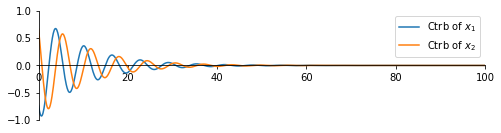

In [13]:
# --> Plot the rows of the controlability matrix.
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(range(Ctrb.shape[1])*Δt, Ctrb[0], label="Ctrb of $x_1$")
ax.plot(range(Ctrb.shape[1])*Δt, Ctrb[1], label="Ctrb of $x_2$")

ax.legend()
ax.set(xlim=(0, 100), ylim=(-1, 1))

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

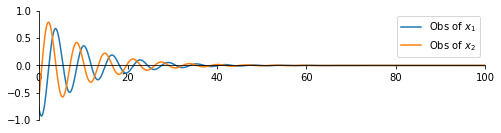

In [14]:
# --> Plot the rows of the controlability matrix.
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(range(Obs.shape[0])*Δt, Obs[:, 0], label="Obs of $x_1$")
ax.plot(range(Obs.shape[0])*Δt, Obs[:, 1], label="Obs of $x_2$")

ax.legend()
ax.set(xlim=(0, 100), ylim=(-1, 1))

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [15]:
# --> Forms the one-step-ahead Hankel matrix.
H̄ = Hankel(y_new[1:])

In [16]:
# --> Extract the dynamics matrix.
A = np.linalg.pinv(Obs) @ H̄ @ np.linalg.pinv(Ctrb)

In [17]:
# --> Wrap the system for easy simulation.
era_sys = dlti(A, B, C, np.zeros((1, 1)), dt=Δt)

In [18]:
# --> Simulate the impulse response of the identified system.
_, y_era = era_sys.impulse(t=np.linspace(0, 400, 4001))

y_era = y_era[0] # Extract the impulse (by default, impulse is more general and can handle multiple input/output)

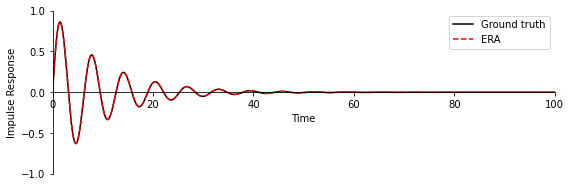

In [19]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t, y, c="k", label="Ground truth")
ax.plot(t, y_era, c="r", ls='--', label="ERA")

ax.set(xlim=(0, 100), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)
ax.legend()

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Convolutional model

Collecting clean impulse response data can be quite challenging in practice, even in a well-controlled lab experiment.
Instead, it is often easier to excite the system with a pseudo-random input, collect the measurements and then try to identify a model from these input/output data.
The data you'll need for this section is generated below.

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

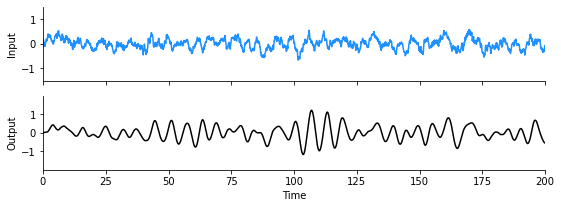

In [113]:
# --> Pseudo-random input.
u_random = moving_average(np.random.randn(2**18), n=21)

# --> Excite the system.
t, y_random, _ = lsim(sys, U=u_random, T=np.arange(len(u_random))*Δt)

# --> Plot the input/output data.
fig, axes = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

axes[0].plot(t, u_random, c="dodgerblue")
axes[0].set(xlim=(t.min(), t.max()), ylim=(-1.5, 1.5))
axes[0].set(yticks=[-1, 0, 1], ylabel="Input")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

axes[1].plot(t, y_random, c="k")
axes[1].set(xlim=(0, 200), ylim=(-2, 2))
axes[1].set(yticks=[-1, 0, 1], ylabel="Output", xlabel="Time")
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

Since the Markov parameters of the system are not readily available, we cannot directly indentify a state-space model.
Instead, we'll turn our attention to convolutional models.
In this framework, the map from the input to the output is given by

$$
y[k] = \sum_{i=0}^N h[i] \cdot u[k-i].
$$

where $\mathbf{h} \in \mathbb{R}^N$ is the kernel of our convolutional model.
It also corresponds to the yet unknown Markov parameters of our system.
In the rest of this section, you need to come up with a way to identify these parameters.

<u>Hint:</u> Consider just a handful of steps and find the map from the input $u_0, u_1, u_2, u_3$ to the output $y_3$, assuming $\mathbf{x}_0 = 0$.
The matrix describing this mapping should be highly structured.

<u>Bonus:</u> Once you solved the problem, if your estimated $\hat{\mathbf{h}}$ is noisy, you can use ideas to similar to what was done in the previous notebook to find a smoother estimate.

[Text(0.5, 0, 'Lag k'), Text(0, 0.5, 'Ryu(k)')]

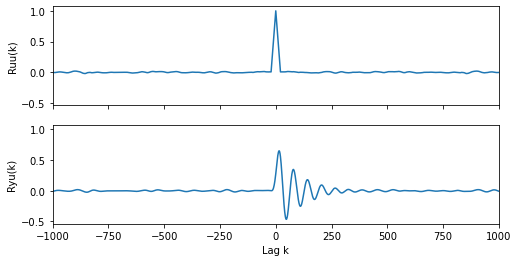

In [114]:
# --> Compute the autocorrelation of the input.
Ruu = correlate(u_random, u_random) / np.linalg.norm(u_random)**2

# --> Compute the cross-correlation between the input and output.
Ryu = correlate(y_random, u_random) / ( np.linalg.norm(u_random) * np.linalg.norm(y_random))
k = (np.arange(len(Ruu)) - len(Ruu)//2)

# --> Plot the correlation functions.
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)

ax[0].plot(k, Ruu)
ax[1].plot(k, Ryu)

ax[0].set(xlim = (-1000, 1000), ylabel="Ruu(k)")
ax[1].set(xlabel="Lag k", ylabel="Ryu(k)")

In [115]:
# --> Number of lags to construct the Toeplitz matrix.
nlag = 500

In [116]:
def toeplitz(x, n):
    # --> Size of input vector.
    m = len(x)
    
    # --> Initialize Toeplitz matrix.
    T = np.zeros((m, n))
    
    # --> Fill-in Toeplitz matrix.
    for j in range(n):
        T[j:, j] = x[:m-j]
    
    return T

In [117]:
# --> Toeplitz matrix build from the input vector.
T = toeplitz(u_random, nlag) * Δt

In [118]:
# --> Solve the least-square problem using numpy.
h = np.linalg.lstsq(T, y_random, rcond=-1)[0]

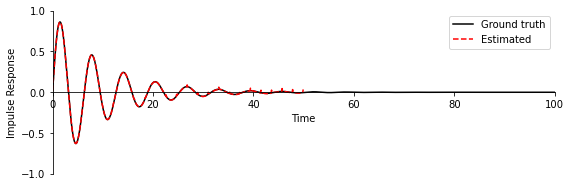

In [120]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(Δt*range(len(y)), y, c="k", label="Ground truth")
ax.plot(Δt*range(len(h)), h, ls="--", c="r", label="Estimated")

ax.set(xlim=(0, 100), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(loc=1)